# Getting started with NLP: Traditional approaches
# Word Embeddings, GloVe and Text classification

In this notebook we are going to explain the concepts and use of word embeddings in NLP, using Glove as en example. Then we will try to apply the pre-trained Glove word embeddings to solve a text classification problem using this technique.

We will use the Reuters dataset from NLTK as a demo of text classification. And as in others notebook we will follow the notebook from the great course on NLP by LazyProgrammer "Natural Language Processing in Python" and his notebook:

https://github.com/lazyprogrammer/machine_learning_examples/blob/master/nlp_class2/bow_classifier.py


## About the data
## Large Movie Review Dataset

This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well. Raw text and already processed bag of words formats are provided. See the README file contained in the release for more details.

Link to dataset:
http://ai.stanford.edu/~amaas/data/sentiment/

Publications Using the Dataset:

*Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011)*.




## Loading the libraries

In [20]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sn
import pickle

%matplotlib inline

#Import module to split the datasets
from sklearn.model_selection import train_test_split
# Import modules to evaluate the metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc

We set the variables for data location.

In [3]:
# Global parameters
#root folder
root_folder='.'
data_folder_name='data'
glove_filename='glove.6B.100d.txt'

train_filename='train.csv'
# Variable for data directory
DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name))
glove_path = os.path.abspath(os.path.join(DATA_PATH, glove_filename))

# Both train and test set are in the root data directory
train_path = DATA_PATH
test_path = DATA_PATH

#Relevant columns
TEXT_COLUMN = 'text'
TARGET_COLUMN = 'target'


## Word embeddings

**What is word embedding?**
Word embeddings are a type of word representation that allows words with similar meaning to have a similar representation. They are a distributed representation for text that is perhaps one of the key breakthroughs for the impressive performance of deep learning methods on challenging natural language processing problems.

Word embeddings are in fact a class of techniques where individual words are represented as real-valued vectors in a predefined vector space. Each word is mapped to one vector and the vector values are learned in a way that resembles a neural network, and hence the technique is often lumped into the field of deep learning. The distributed representation is learned based on the usage of words. This allows words that are used in similar ways to result in having similar representations, naturally capturing their meaning. 

Neural network embeddings have 3 primary purposes:
- Finding nearest neighbors in the embedding space. These can be used to make recommendations based on user interests or cluster categories.
- As input to a machine learning model for a supervised task.
- For visualization of concepts and relations between categories.

**How can we obtain the word embedings?**
1. **Embedding Layer**

An embedding layer is a word embedding that is learned in a neural network model on a specific natural language processing task. The documents or corpus of the task are cleaned and prepared and the size of the vector space is specified as part of the model, such as 50, 100, or 300 dimensions. The vectors are initialized with small random numbers. The embedding layer is used on the front end of a neural network and is fit in a supervised way using the Backpropagation algorithm. 

It is a flexible layer that can be used in a variety of ways, such as:

- It can be used alone to learn a word embedding that can be saved and used in another model later.
- It can be used as part of a deep learning model where the embedding is learned along with the model itself.
- It can be used to load a pre-trained word embedding model, a type of transfer learning.

This approach requires a lot of training data and can be very slow, but will learn an embedding both targeted to the specific text data and the NLP task we are interested.

2. **Word2Vec**

Word2Vec is a statistical method for efficiently learning a standalone word embedding from a text corpus. It was developed by Tomas Mikolov, et al. at Google in 2013 as a response to make the neural-network-based training of the embedding more efficient and since then has become the de facto standard for developing pre-trained word embedding.

It learns the word embedding in one of two ways:
- either using context to predict a target word, a method known as continuous bag of words, or CBOW
- or using a word to predict a target context, which is called skip-gram, for example, we’d like to predict c context words having one target word on the input. 
The latter method usually produces more accurate results on large datasets.

![CBOW model](images/CBOW.png "CBOW Model")

A well trained set of word vectors will place similar words close to each other in that space. The words oak, elm and birch might cluster in one corner, while war, conflict and strife huddle together in another.

3. **Glove**

The Global Vectors for Word Representation, or GloVe, algorithm is an extension to the word2vec method for efficiently learning word vectors, developed by Pennington, et al. at Stanford. GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space.

GloVe is an approach to marry both the global statistics of matrix factorization techniques like LSA (Latent Semantic Analysis) with the local context-based learning in word2vec. Rather than using a window to define local context, GloVe constructs an explicit word-context or word co-occurrence matrix using statistics across the whole text corpus.

An extensive explanation on the next link:
Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation. 
https://nlp.stanford.edu/pubs/glove.pdf

4. **Fasttext** 

fastText is another word embedding method that is an extension of the word2vec model. Instead of learning vectors for words directly, fastText represents each word as an n-gram of characters. The FastText model takes into account internal structure of words by splitting them into a bag of character n-grams and adding to them a whole word as a final feature. If we denote n-gram vector as z and v as output vector representation of word w (context word):

$$s(w,c)=\sum_{g\in G_w}z^T_gv_c$$

We can choose n-grams of any size, but in practice size from 3 to 6 is the most suitable one.

This helps capture the meaning of shorter words and allows the embeddings to understand suffixes and prefixes. A skip-gram model is trained to learn the embeddings. This model is considered to be a bag of words model with a sliding window over a word. fastText works well with rare words. So even if a word wasn’t seen during training, it can be broken down into n-grams to get its embeddings.


#### Links
https://towardsdatascience.com/neural-network-embeddings-explained-4d028e6f0526


## Loading a pre-trained word embedding: GloVe

Files with the pre-trained vectors Glove can be found in many sites like Kaggle or in the previous link of the Stanford University. We will use the glove.6B.100d.txt file containing the glove vectors trained on the Wikipedia and GigaWord dataset.

First we convert the GloVe file containing the word embeddings to the word2vec format for convenience of use. We can do it using the gensim library, a function called glove2word2vec.

In [4]:
# We just need to run this code once, the function glove2word2vec saves the Glove embeddings in the word2vec format 
# that will be loaded in the next section
from gensim.scripts.glove2word2vec import glove2word2vec

#glove_input_file = glove_filename
word2vec_output_file = glove_filename+'.word2vec'
glove2word2vec(glove_path, word2vec_output_file)

(400000, 100)

So our vocabulary contains 400K words represented by a feature vector of shape 100. Now we can load the Glove embeddings in word2vec format and then analyze some analogies. In this way if we want to use a pre-trained word2vec embeddings we can simply change the filename and reuse all the code below.

In [5]:
from gensim.models import KeyedVectors
# load the Stanford GloVe model
word2vec_output_file = glove_filename+'.word2vec'
model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

#Show a word embedding
print('King: ',model.get_vector('king'))

result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)

print('Most similar word to King + Woman: ', result)

King:  [-0.32307  -0.87616   0.21977   0.25268   0.22976   0.7388   -0.37954
 -0.35307  -0.84369  -1.1113   -0.30266   0.33178  -0.25113   0.30448
 -0.077491 -0.89815   0.092496 -1.1407   -0.58324   0.66869  -0.23122
 -0.95855   0.28262  -0.078848  0.75315   0.26584   0.3422   -0.33949
  0.95608   0.065641  0.45747   0.39835   0.57965   0.39267  -0.21851
  0.58795  -0.55999   0.63368  -0.043983 -0.68731  -0.37841   0.38026
  0.61641  -0.88269  -0.12346  -0.37928  -0.38318   0.23868   0.6685
 -0.43321  -0.11065   0.081723  1.1569    0.78958  -0.21223  -2.3211
 -0.67806   0.44561   0.65707   0.1045    0.46217   0.19912   0.25802
  0.057194  0.53443  -0.43133  -0.34311   0.59789  -0.58417   0.068995
  0.23944  -0.85181   0.30379  -0.34177  -0.25746  -0.031101 -0.16285
  0.45169  -0.91627   0.64521   0.73281  -0.22752   0.30226   0.044801
 -0.83741   0.55006  -0.52506  -1.7357    0.4751   -0.70487   0.056939
 -0.7132    0.089623  0.41394  -1.3363   -0.61915  -0.33089  -0.52881
  0.16483  -

## Analyzing the vector space and find analogies

We would like extract some interesting features of our word embeddings,Now, our words are numerical vectors so we can measure and compare distances between words to show some of the properties that these embedding provide.

For example, we can compare some analogies. The most famous is the following: king – man + woman = queen. In other words, adding the vectors associated with the words king and woman while subtracting man is equal to the vector associated with queen. In others words, subtracting the concept of man to the concept of King we get a representation of the "royalty". Then, if we sum to the woman word this concept we obtain the word "queen". Another example is: france – paris + rome = italy. In this case, the vector difference between paris and france captures the concept of country.

Now we will show some of thise analogies in different topics.


In [6]:
result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print('King - Man + Woman = ',result)
result = model.most_similar(positive=['rome', 'france'], negative=['paris'], topn=1)
print('France - Paris + Rome = ',result)
result = model.most_similar(positive=['english', 'france'], negative=['french'], topn=1)
print('France - french + english = ',result)
result = model.most_similar(positive=['june', 'december'], negative=['november'], topn=1)
print('December - November + June = ',result)
result = model.most_similar(positive=['sister', 'man'], negative=['woman'], topn=1)
print('Man - Woman + Sister = ',result)


King - Man + Woman =  [('queen', 0.7698541283607483)]
France - Paris + Rome =  [('italy', 0.8295994400978088)]
France - french + english =  [('england', 0.7678162455558777)]
December - November + June =  [('july', 0.9814669489860535)]
Man - Woman + Sister =  [('brother', 0.8288711905479431)]


We can observe how the word vectors include information to relate countries with nationalities, months of the year, family relationships, etc.

But not always we get the expected results:

In [7]:
#But not always we get the expected result
result = model.most_similar(positive=['aunt', 'nephew'], negative=['niece'], topn=1)
print('France - Paris + Rome = ',result)

France - Paris + Rome =  [('uncle', 0.8936851024627686)]


We can extract wich words are more similar to another word, so they all are "very close" in the vector space.

In [8]:
result = model.most_similar(positive=['spain'], topn=10)
print('10 most similar words to Spain: ',result)

result = model.most_similar(positive=['football'], topn=10)
print('\n10 most similar words to Football: ',result)

result = model.most_similar(positive=['doctor'], topn=10)
print('\n10 most similar words to Doctor: ',result)

10 most similar words to Spain:  [('portugal', 0.797070324420929), ('argentina', 0.7758234143257141), ('italy', 0.7746187448501587), ('france', 0.7557463645935059), ('spanish', 0.734722375869751), ('brazil', 0.724494457244873), ('mexico', 0.7206876277923584), ('madrid', 0.7078269124031067), ('morocco', 0.7001036405563354), ('netherlands', 0.6802704334259033)]

10 most similar words to Football:  [('soccer', 0.8732221126556396), ('basketball', 0.855563759803772), ('league', 0.8153362274169922), ('rugby', 0.8007533550262451), ('hockey', 0.7833694219589233), ('club', 0.7730998396873474), ('team', 0.7720499038696289), ('baseball', 0.7605736255645752), ('players', 0.7399718761444092), ('player', 0.7376238107681274)]

10 most similar words to Doctor:  [('physician', 0.7673239707946777), ('nurse', 0.75215083360672), ('dr.', 0.7175193428993225), ('doctors', 0.7080885171890259), ('patient', 0.7074184417724609), ('medical', 0.6995993256568909), ('surgeon', 0.6905338764190674), ('hospital', 0.690

In [9]:
#Lets show some measure of similarities between words
result = model.similar_by_word("cat")
print(" Cat is similar to {}: {:.4f}".format(*result[0]))
result = model.similar_by_word("father")
print(" Father is similar to {}: {:.4f}".format(*result[0]))

 Cat is similar to dog: 0.8798
 Father is similar to son: 0.9240


The idea behind all of the word embeddings is to capture with them as much of the semantical/morphological/context/hierarchical/etc. information as possible, but in practice one methods are definitely better than the other for a particular task (for instance, LSA is quite effective when working in low-dimensional space for the analysis of incoming documents from the same domain zone as the ones, which are already processed and put into the term-document matrix). The problem of choosing the best embeddings for a particular project is always the problem of try-and-fail approach, so realizing why in particular case one model works better than the other sufficiently helps in real work.



### Visualization of word embeddings

Another exciting operation we can do with embeddings is visualization, plotting them in a 2D dimensional space can show us how words are related. Most similar words should be plotted in groups while non related words will appear in a large distance. This requires a further dimension reduction technique to get the dimensions to 2 or 3. The most popular technique for reduction is itself an embedding method: t-Distributed Stochastic Neighbor Embedding (TSNE).

**t-SNE stands for t-distributed stochastic neighbor embedding. It is a technique for dimensionality reduction that is best suited for the visualization of high dimensional data-set.**

TSNE is a manifold learning technique which means that it tries to map high-dimensional data to a lower-dimensional manifold, creating an embedding that attempts to maintain local structure within the data. It's almost exclusively used for visualization because the output is stochastic and it does not support transforming new data.

In [10]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction
import numpy as np                                  # array handling

def display_closestwords_tsnescatterplot(model, dim, words):
    
    arr = np.empty((0,dim), dtype='f')
    word_labels = words

    # get close words
    #close_words = [model.similar_by_word(word) for word in words]
    
    # add the vector for each of the closest words to the array
    close_words=[]
    for word in words:
        arr = np.append(arr, np.array([model[word]]), axis=0)
        close_words +=model.similar_by_word(word)
        
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    #np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()
    
def tsne_plot(model, words):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    #for word in model.wv.vocab:
    for word in words:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(14, 10)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

For example, we will plot a hundred words from our word embeddings and also the most similar words to the concept of woman and car. All similar words should be plotted closely, while the rest of words will apear distributed across the vector space: 

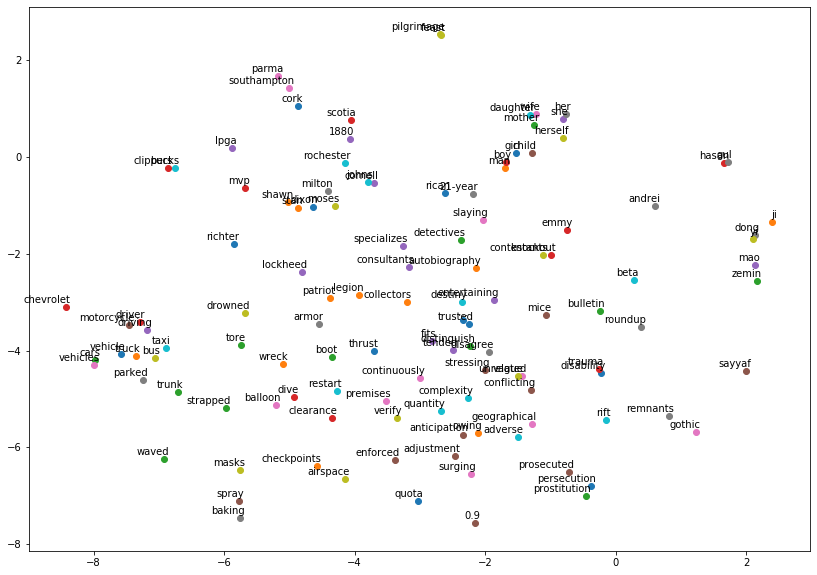

In [11]:
#display_closestwords_tsnescatterplot(model, 100, ['man', 'dog'])
words=list(model.vocab.keys())
word1 = words[10000:10100]
words2= model.similar_by_word('woman')
words3= model.similar_by_word('car')
words= word1 + [w[0] for w in words2] + [w[0] for w in words3]
#print(words)
tsne_plot(model, words)

In the previous picture, we can observe how the most similar words to "woman" and "car" are very close, while other bunch of words are distributed uniformly on the vector space.

### Loading the dataset

Out IMdb reviews can be loaded from keras.dataset. But in this dataset the tokens has already been "numericalized", but we want them as plain text, so we need to reverse them to the original tokens. Then, we load the dataset, load the vocabulary and we will use the vocab to get the original token for every single token in the whole dataset.

In [12]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=None)

word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

review = [reverse_word_index.get(i-3, "") for i in train_data[0]]

Using TensorFlow backend.


In [13]:
print('Vocabulary lenght: ',len(word_index))
print('Review example: ',review[:20])
print('Label: ',train_labels[0])

Vocabulary lenght:  88584
Review example:  ['', 'this', 'film', 'was', 'just', 'brilliant', 'casting', 'location', 'scenery', 'story', 'direction', "everyone's", 'really', 'suited', 'the', 'part', 'they', 'played', 'and', 'you']
Label:  1


In [14]:
# Convert the train and test dataset to strings of words
X_train=[]
for doc in train_data:
    X_train.append(' '.join([reverse_word_index.get(i - 3, "") for i in doc]))

X_test=[]
for doc in test_data:
    X_test.append(' '.join([reverse_word_index.get(i - 3, "") for i in doc]))


In [15]:
print(len(X_train),len(X_test))
print(X_train[0])

25000 25000
 this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing an

## Applying the word embedding to a text classification task

Now, we have our word representation, a vector for every word in our vocabulary. But we need to deal with full sentences so we need to create a sentence embedding, basically we need a vector that represent the whole sentence and every feature in the vector will be based on the word embeddings. There are many posibilities and we are notr going to cover this topic, so we apply a very simple method: the ith value in the sentence embedding will be the mean of the ith values in the word embedding of all the words in the sentence. 

We will create a class that will contain our vocabulary and glove vectors and then it will transform every review (a sentence in our example) to a vector representation as we describe previously.

In [16]:
class Word2VecVectorizer:
  def __init__(self, model):
    print("Loading in word vectors...")
    self.word_vectors = model
    print("Finished loading in word vectors")

  def fit(self, data):
    pass

  def transform(self, data):
    # determine the dimensionality of vectors
    v = self.word_vectors.get_vector('king')
    self.D = v.shape[0]

    X = np.zeros((len(data), self.D))
    n = 0
    emptycount = 0
    for sentence in data:
      tokens = sentence.split()
      vecs = []
      m = 0
      for word in tokens:
        try:
          # throws KeyError if word not found
          vec = self.word_vectors.get_vector(word)
          vecs.append(vec)
          m += 1
        except KeyError:
          pass
      if len(vecs) > 0:
        vecs = np.array(vecs)
        X[n] = vecs.mean(axis=0)
      else:
        emptycount += 1
      n += 1
    print("Numer of samples with no words found: %s / %s" % (emptycount, len(data)))
    return X


  def fit_transform(self, data):
    self.fit(data)
    return self.transform(data)

Next, we create a Vectorizer object that will help us to transform our reviews to vectors, a numerical representation. Then we can use those vectors to feed our classifier.

In [17]:
# Set a word vectorizer
vectorizer = Word2VecVectorizer(model)
# Get the sentence embeddings for the train dataset
Xtrain = vectorizer.fit_transform(X_train)
Ytrain = train_labels
# Get the sentence embeddings for the test dataset
Xtest = vectorizer.transform(X_test)
Ytest = test_labels


Loading in word vectors...
Finished loading in word vectors
Numer of samples with no words found: 0 / 25000
Numer of samples with no words found: 0 / 25000


In [35]:
print(Xtrain.shape,Xtest.shape)

(25000, 100) (25000, 100)


## Train a classifier on the sentence embeddings

As text classification is just a type of classification problem we can apply some of the well-known classifiers to predict the label of a text. The next cells build different models to solve our classification task.

But first we create some helper functions to plot the results: 

In [19]:
# Create the confussion matrix
def plot_confussion_matrix(y_test, y_pred):
    ''' Plot the confussion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confussion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))
    #plt.figure(figsize = (10,7))
    # Plot the confussion matrix
    sn.set(font_scale=1.4) #for label size
    sn.heatmap(df_cm, annot=True,fmt='.0f',annot_kws={"size": 10})# font size
    plt.show()
    
# ROC Curve
# plot no skill
# Calculate the points in the ROC curve
def plot_roc_curve(y_test, y_pred):
    ''' Plot the ROC curve for the target labels and predictions'''
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc= auc(fpr,tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    

### A random forest classifier

First, we try with a simple model, a Random Forest. It can be considered as a baseline benchmark to any binary clasification problem.

This notebook is about word embeddings, so we are not covering or interested in building the best classifier. We want to show us how to use the embeddings in a very simple way.

In [18]:
from sklearn.ensemble import RandomForestClassifier

# create the model, train it, print scores
clf = RandomForestClassifier(n_estimators=200)

clf.fit(Xtrain, Ytrain)

print("train score:", clf.score(Xtrain, Ytrain))
print("test score:", clf.score(Xtest, Ytest))


train score: 1.0
test score: 0.76


              precision    recall  f1-score   support

           0    0.76895   0.74336   0.75594     12500
           1    0.75163   0.77664   0.76393     12500

    accuracy                        0.76000     25000
   macro avg    0.76029   0.76000   0.75993     25000
weighted avg    0.76029   0.76000   0.75993     25000



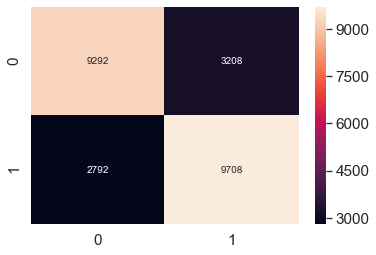

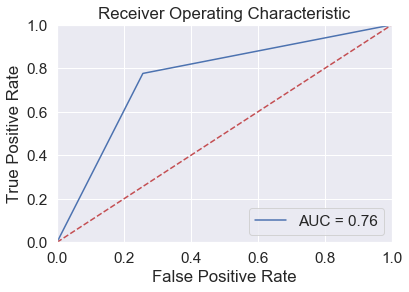

In [28]:
# Predicting the Test set results
y_pred = clf.predict(Xtest)

print(metrics.classification_report(Ytest, y_pred,  digits=5))
plot_confussion_matrix(Ytest, y_pred)
plot_roc_curve(Ytest, y_pred)

## Suport Vector Machine Classifier
### What is Support Vector Machines?

*The objective of the support vector machine algorithm is to find a hyperplane in an N-dimensional space(N — the number of features) that distinctly classifies the data points.*

In a binary classification problem, to separate the two classes of data points, there are many possible hyperplanes that could be chosen. Our objective is to find a plane that has the maximum margin, i.e the maximum distance between data points of both classes. Maximizing the margin distance provides some reinforcement so that future data points can be classified with more confidence. Support vectors are data points that are closer to the hyperplane and influence the position and orientation of the hyperplane. Using these support vectors, we maximize the margin of the classifier.

We can use SVM algorithm to predict if a review is positive or genative, it is just a binary classifcation problem. We use GridSearch to fine tune some of the hyperparameters of the model. 

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the parameters to tune
parameters = { 
    'C': [1.0, 10],
    'gamma': [1, 'auto', 'scale']
}
# Tune yyperparameters  using Grid Search and a SVM model
model = GridSearchCV(SVC(kernel='rbf'), parameters, cv=5, n_jobs=-1).fit(Xtrain, Ytrain)

Once our model is trained we can evaluate the performance as we did previously:

              precision    recall  f1-score   support

           0    0.81298   0.81688   0.81492     12500
           1    0.81600   0.81208   0.81403     12500

    accuracy                        0.81448     25000
   macro avg    0.81449   0.81448   0.81448     25000
weighted avg    0.81449   0.81448   0.81448     25000



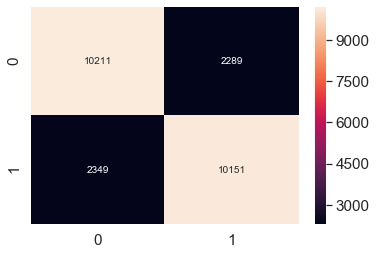

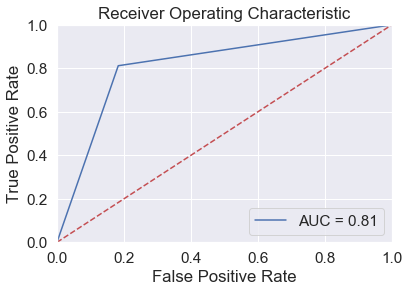

In [24]:
# Predicting the Test set results
y_pred = model.predict(Xtest)

print(metrics.classification_report(Ytest, y_pred,  digits=5))
plot_confussion_matrix(Ytest, y_pred)
plot_roc_curve(Ytest, y_pred)

## XGBoost classifier

XGBoost is an implementation of gradient boosted decision trees designed for speed and performance that is dominative competitive machine learning. XGBoost is an advanced version of gradient boosting, rather than training all of the models in isolation of one another, boosting trains models in succession, with each new model being trained to correct the errors made by the previous ones. Models are added sequentially until no further improvements can be made.

XGBoost provides a wrapper class to allow models to be treated like classifiers or regressors in the scikit-learn framework. This means we can use the full scikit-learn library with XGBoost models.

In [26]:
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score


def f1_metric(ytrue,preds):
    ''' Return the F1 Score value for the preds and true values, ytrue '''
    return 'f1_score', f1_score((preds>=0.5).astype('int'), ytrue, average='macro'), True

params = {
    'learning_rate': 0.06,
    'n_estimators': 1500,
    'colsample_bytree': 0.5,
    'metric': 'f1_score'
}

full_clf = LGBMClassifier(**params)

# Fit or train the xgboost model
full_clf.fit(Xtrain.astype(np.float32), Ytrain, eval_set=[(Xtrain.astype(np.float32), Ytrain), (Xtest.astype(np.float32), Ytest)],
             verbose=400, eval_metric=f1_metric)
#Show the results
print("train score:", full_clf.score(Xtrain.astype(np.float32), Ytrain))
print("test score:", full_clf.score(Xtest.astype(np.float32), Ytest))

[400]	valid_0's f1_score: 0.939439	valid_1's f1_score: 0.794031
[800]	valid_0's f1_score: 0.98856	valid_1's f1_score: 0.795111
[1200]	valid_0's f1_score: 0.99912	valid_1's f1_score: 0.795115
train score: 0.99996
test score: 0.7964


              precision    recall  f1-score   support

           0    0.81298   0.81688   0.81492     12500
           1    0.81600   0.81208   0.81403     12500

    accuracy                        0.81448     25000
   macro avg    0.81449   0.81448   0.81448     25000
weighted avg    0.81449   0.81448   0.81448     25000



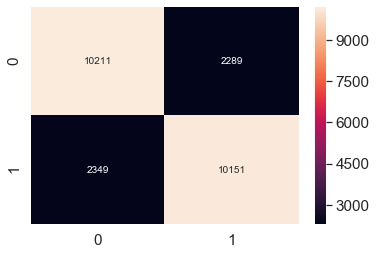

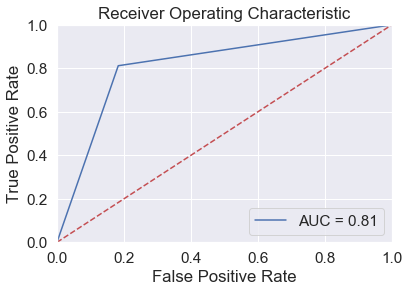

In [27]:
# Predicting the Test set results
Y_pred = full_clf.predict(Xtest.astype(np.float32))

print(metrics.classification_report(Ytest, y_pred,  digits=5))
plot_confussion_matrix(Ytest, y_pred)
plot_roc_curve(Ytest, y_pred)

### Links

Link to blog post or aditional readings: 

https://machinelearningmastery.com/what-are-word-embeddings/

https://machinelearningmastery.com/develop-word-embeddings-python-gensim/
